<p>This notebook is my solution for <a href=https://ocw.mit.edu/courses/aeronautics-and-astronautics/16-20-structural-mechanics-fall-2002/assignments/dp3.pdf>Design Problem #3</a> of the Structural Mechanics course of MIT Open Course Work.</br>

Paul Lagace. 16.20 Structural Mechanics. Fall 2002. Massachusetts Institute of Technology: MIT OpenCourseWare, https://ocw.mit.edu. License: Creative Commons BY-NC-SA.</p>

In [ ]:
import numpy as np
import sympy as sp
from sympy import init_printing
init_printing(use_latex=True)
from sympy.utilities.lambdify import lambdify

In [2]:
# All the material properties for base and piezoelectric materials
al_7075_T6 = {'E_L':70e9, 'E_T':70e9, 'nu':0.3, 'a_L':12.9*1.8e-6, 'a_T':12.9*1.8e-6,
              'rho':2.8e3, 'price':60*2.204, 'name':'AL 7075-T6'}
Ti_6Al_4V = {'E_L':107e9, 'E_T':107e9, 'nu':0.3, 'a_L':5*1.8e-6, 'a_T':5*1.8e-6,
             'rho':4.43e3, 'price':85*2.204, 'name':'Ti-6Al-4V'}
AS4_3501_6 = {'E_L':80e9, 'E_T':30e9, 'nu':0.43, 'a_L':4.2*1.8e-6, 'a_T':7.3*1.8e-6,
              'rho':1.54e3, 'price':140*2.204, 'name':'Graphite/Epoxy AS4/3501-6'}
P70_5501_6 = {'E_L':170e9, 'E_T':25e9, 'nu':0.45, 'a_L':2.1*1.8e-6, 'a_T':6.3*1.8e-6,
              'rho':1.6e3, 'price':300*2.204, 'name':'Graphite/Epoxy P70/3501-6'}
base_materials = [al_7075_T6, Ti_6Al_4V, AS4_3501_6, P70_5501_6]

pzt_4 = {'E':64e9, 'nu':0.31, 'a':4.5e-6, 'd_113':-0.123e3, 'd_333':0.289e3,
         'Ek':10e5, 'rho':7.5e3, 'price':5600*2.204, 'name':'PZT 4'}
pzt_5H = {'E':48e9, 'nu':0.31, 'a':4.5e-6, 'd_113':-0.274e3, 'd_333':0.593e3,
         'Ek':4e5, 'rho':7.5e3, 'price':5600*2.204, 'name':'PZT 5H'}
pzt_5A = {'E':53e9, 'nu':0.31, 'a':4.5e-6, 'd_113':-0.171e3, 'd_333':0.374e3,
         'Ek':7e5, 'rho':7.5e3, 'price':5600*2.204, 'name':'PZT 5A'}
piezo_materials = [pzt_4, pzt_5H, pzt_5A]

In [12]:
T_min = -75  # deg C
T_max = 100  # deg C
Length = 29  # m
displacement = 0.01  # m

In [3]:
s_b1, E_bl, a_bl, dT = sp.symbols('sigma_b1, E_bl, alpha_bl dT')
s_p1, E_p, a_p, d_113, E_k = sp.symbols('sigma_p1, E_p, alpha_p, d_113, E_k')
t_b, t_p, L, L_d, x, du = sp.symbols('t_b, t_p, L, L_d, x, du')

Base material strain equation:


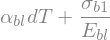

In [4]:
# Equation for strain of the base material
e_m_b1 = s_b1/E_bl
e_t_b1 = a_bl*dT
e_b1 = e_m_b1 + e_t_b1
print("Base material strain equation:")
e_b1

Piezoelectric material strain equation:


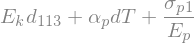

In [5]:
# strain of the piezoelectric material
e_m_p1 = s_p1/E_p
e_t_p1 = a_p*dT
e_p_p1 = d_113*E_k
e_p1 = e_m_p1 + e_t_p1 + e_p_p1
print("Piezoelectric material strain equation:")
e_p1

In [6]:
# equation for equilibrating stress in the cross section
# the composite structure must be in equilibrium with no
# net forces and stresses that cancel out based on the 
# stress in each material and their cross-section area
equilibrating_stress = sp.integrate(s_b1, (x, -t_b-t_p/2, -t_p/2))\
    + sp.integrate(s_p1, (x, -t_p/2, t_p/2))\
    + sp.integrate(s_b1, (x, t_p/2, t_p/2 + t_b))
print("Relationship of self-equilibrating stresses:")
sp.simplify(equilibrating_stress)

Relationship of self-equilibrating stresses:


Base material stress equation:


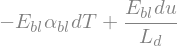

In [8]:
# solve for the base material stress based on displacement integrated from the
# strain equation over the length of the structure
u_b = sp.integrate(e_b1, (x, 0, L_d))
stress_b1 = sp.solve(u_b - du, s_b1)[0]
stress_b1_func = lambdify((E_bl, a_bl, dT, L_d, du), stress_b1)
print("Base material stress equation:")
sp.simplify(stress_b1)

Piezo material stress equation:


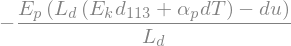

In [9]:
# piezo material stress equation, solve just like base material above
u_p = sp.integrate(e_p1, (x, 0, L_d))
stress_p1 = sp.solve(u_p - du, s_p1)[0]
stress_p1_func = lambdify((E_p, a_p, d_113, E_k, dT, L_d, du), stress_p1)
print("Piezo material stress equation:")
sp.simplify(stress_p1)

Piezo material electric field equation:


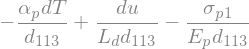

In [10]:
# solve for the electric field variable from the piezo material displacement
# equation
Efield_p1 = sp.solve(u_p - du, E_k)[0]
Efield_p1_func = lambdify((E_p, a_p, d_113, s_p1, dT, L_d, du), Efield_p1)
print("Piezo material electric field equation:")
sp.simplify(Efield_p1)

In [11]:
def thermal_strain(a, dT):
    return a*dT

def mech_strain(stress, E):
    return stress/E

def piezo_strain(d, Ek):
    return d*Ek

In [46]:
for base in base_materials:
    # calculate min and max stresses to keep the base material at the
    # design displacement limit
    s_b_min = stress_b1_func(base['E_L'], base['a_L'], T_min, Length, -displacement)
    s_b_max = stress_b1_func(base['E_L'], base['a_L'], T_max, Length, displacement)
    
    print(f"For base material: {base['name']}:")
    for piezo in piezo_materials:
        # calculate stress for min displacement of the piezo material
        # this should be negative to compress material to design displacement
        s_p_min = stress_p1_func(piezo['E'], piezo['a'], piezo['d_113'],
                                 0, T_min, Length, -displacement)
        # calculate ratio of thicknesses based on stresses to reach design
        # displacement at -75 deg C
        t_ratio = -s_p_min/(2*s_b_min)
        if t_ratio < 0:
            s_p_max = stress_p1_func(piezo['E'], piezo['a'], piezo['d_113'],
                                     piezo['Ek']/10, T_max, Length, displacement)
            t_ratio = -s_p_max/(2*s_b_max)
            delta_T = 100
            delta_u = 0.01
            s_p_min = -t_ratio*2*s_b_min
        else:
            s_p_max = -t_ratio*2*s_b_max
            delta_T = 100
            delta_u = 0.01
        
        # calculate electric field needed to have piezo strain match max displacement
        # this uses max piezo stress based on the stress and thickness ratio of
        # base material at 100 deg C
        Efield = Efield_p1_func(piezo['E'], piezo['a'], piezo['d_113'], s_p_max,
                                delta_T, Length, delta_u)

        # check the max and min displacements of the piezo to confirm strain
        # meets design requirements
        du_max = thermal_strain(piezo['a'], T_max)*Length\
            + mech_strain(s_p_max, piezo['E'])*Length\
            + piezo_strain(piezo['d_113'], Efield)*Length
        
        du_min = thermal_strain(piezo['a'], T_min)*Length\
            + mech_strain(s_p_min, piezo['E'])*Length
        
        print(f"    with {piezo['name']}:")
        print(f"        tb/tp = {t_ratio:.5f}")
        print(f"        Ek = {Efield:.3e} V/m")
        print(f"        V/tb = {Efield/t_ratio:.3e} V")
        if Efield > piezo['Ek']/2:
            print(" "*12 + f"required electric field will depole the piezo")
        if du_max > displacement*1.01:
            print(" "*8 + f"max displacement too great.")
            print(f"        du = {du_max:.3f} m")
        if du_min < -displacement*1.01:
            print(" "*8 + f"min displacement too great.")
            print(f"        du = {du_min:.3f} m")
        
        # cost estimate - price for piezo / price for base
        cost_ratio = t_ratio*(base['rho']/piezo['rho'])*(base['price']/piezo['price'])
        print(" "*8 + f"cost ratio is {1/cost_ratio:.2f}")
    print("")

For base material: AL 7075-T6:
    with PZT 4:
        tb/tp = 0.00240
        Ek = 9.394e-07 V/m
        V/tb = 3.917e-04 V
        cost ratio is 104236.95
    with PZT 5H:
        tb/tp = 0.00180
        Ek = 4.217e-07 V/m
        V/tb = 2.344e-04 V
        cost ratio is 138982.60
    with PZT 5A:
        tb/tp = 0.00199
        Ek = 6.757e-07 V/m
        V/tb = 3.402e-04 V
        cost ratio is 125871.03

For base material: Ti-6Al-4V:
    with PZT 4:
        tb/tp = 0.00664
        Ek = 9.552e-07 V/m
        V/tb = 1.439e-04 V
        cost ratio is 16805.07
    with PZT 5H:
        tb/tp = 0.00498
        Ek = 4.288e-07 V/m
        V/tb = 8.614e-05 V
        cost ratio is 22406.76
    with PZT 5A:
        tb/tp = 0.00550
        Ek = 6.871e-07 V/m
        V/tb = 1.250e-04 V
        cost ratio is 20292.91

For base material: Graphite/Epoxy AS4/3501-6:
    with PZT 4:
        tb/tp = 0.01319
        Ek = 9.653e-07 V/m
        V/tb = 7.317e-05 V
        cost ratio is 14766.23
    with 

Equation for the electric field as a function of temperature change, material properties, and the max design displacement:


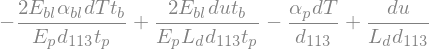

In [38]:
# equation for electric field given a temperature change great enough to
# displace the structure beyond the limit

# piezo stress in terms of the base material and thickness ratio
stress_peizo = -2*stress_b1*(t_b/t_p)
# substitute this into the electric field equation
print("Equation for the electric field as a function of temperature change,"
      " material properties, and the max design displacement:")
sp.expand(Efield_p1_func(E_p, a_p, d_113, stress_peizo, dT, L_d, du))

<p>The choice is really between the two different graphite/epoxy composites, given that their thermal coefficients are low and close to the piezoelectric. This means less piezo can be used and there is a smaller displacement to counteract at the extreme temperature ends.</br>

Because the thermal coefficient for the P70/3501-6 composite is less than the piezo electric, there is no concern of displacement at the lower temperature end. The composite contracts 0.0082m and the piezoelectric contracts 0.0098 m; and both are within the limit of 0.0100 m. The tradeoff is a need for a greater electric at the high end of the temperature range.</br>

However, we can calculate a thickness ratio between base and piezoelectric to meet a desired electric field, and this combination will require far less piezoelectric than the others. This is because the base material has more favorable thermal properties and we want that to dominate the overall properties of the structure. With far less piezoelectric, the higher electric field does not equate to greater voltage because a thinner dieletric will have a greater field strength at the same voltage. </br>

On the required voltage, all structure combinations only require an electric field when the structure is in the sun and power can be supplied via solar panels. Given this, reducing the initial cost should be prioritized. With the P70/3501-6 base, the ratio of base material to piezo is so great that the normalized cost calculated above is essentially zero.</br>

It is recommended to use P70/3501-6 base material with PZT 5H piezoelectric material for this structure.</p>